Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split, GridSearchCV, KFold,
    TunedThresholdClassifierCV
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    ConfusionMatrixDisplay, RocCurveDisplay, classification_report,
    confusion_matrix, make_scorer
)
from sklearn.model_selection import TunedThresholdClassifierCV
import matplotlib.pyplot as plt

Importing Data

In [ ]:
train_file_path = "\Mushroom Competition\mush_train.csv"
test_file_path = "\Mushroom Competition\mush_test.csv"
train_df = pd.read_csv(train_file_path).set_index('Id')
test_df = pd.read_csv(test_file_path).set_index('Id')

print("Full train dataset shape is {}".format(train_df.shape))

print("Full test dataset shape is {}".format(test_df.shape))

Full train dataset shape is (6499, 7)
Full test dataset shape is (1625, 6)


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\MSI\AppData\Local\Temp\ipykernel_21076\2810627735.py:1: SyntaxWarning: invalid escape sequence '\D'
  train_file_path = "C:\DSAI-02\Machine Learning\Mushroom Competition\mush_train.csv"
C:\Users\MSI\AppData\Local\Temp\ipykernel_21076\2810627735.py:2: SyntaxWarning: invalid escape sequence '\D'
  test_file_path = "C:\DSAI-02\Machine Learning\Mushroom Competition\mush_test.csv"


# Without Stacking

In this approach, we will train individual models without stacking them.

In [ ]:


# 1. Data Preparation
X = train_df
y = X.pop('poisonous')
X = X.astype(str)
test_df[X.columns]

# 2. Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)


# 3. Tuning 

# pipelines
pipeline_ohe = make_pipeline(
    OneHotEncoder(),
    RandomForestClassifier(random_state=314)
)
pipeline_target = make_pipeline(
    TargetEncoder(target_type='binary'),
    RandomForestClassifier(random_state=314)
)

# parameter grids
ohe_params = {
    'onehotencoder__handle_unknown': ['ignore'],
    'onehotencoder__drop': [None],
    'randomforestclassifier__n_estimators': [50],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_leaf': [1]
}
target_params = {
    'targetencoder__smooth': range(4, 6),
    'randomforestclassifier__n_estimators': [50],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_leaf': [1]
}

# Run Grid Search for OneHotEncoder 
print(" Grid Search for OneHotEncoder")
grid_search_ohe = GridSearchCV(pipeline_ohe, ohe_params, cv=5, scoring='accuracy')
grid_search_ohe.fit(X_train, y_train)
print(f"Best score for OHE: {grid_search_ohe.best_score_:.4f}\n")

# Run Grid Search for TargetEncoder 
print(" Grid Search for TargetEncoder")
grid_search_target = GridSearchCV(pipeline_target, target_params, cv=5, scoring='accuracy')
grid_search_target.fit(X_train, y_train) 
print(f"Best score for TargetEncoder: {grid_search_target.best_score_:.4f}\n")

 Grid Search for OneHotEncoder
Best score for OHE: 0.9565

 Grid Search for TargetEncoder
Best score for TargetEncoder: 0.9567



In [127]:
grid_search_target.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 50,
 'targetencoder__smooth': 5}

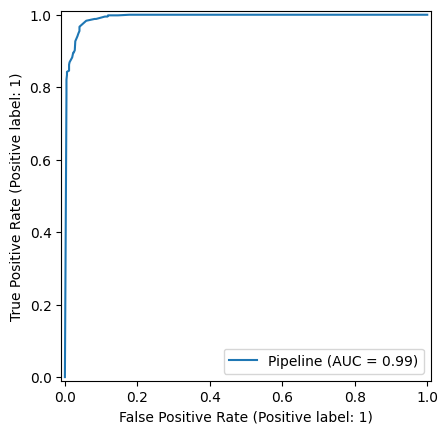


--- Final Evaluation on Test Set with Tuned Threshold ---
Final Accuracy: 0.93
Final Precision: 0.8689
Final Recall: 1.0



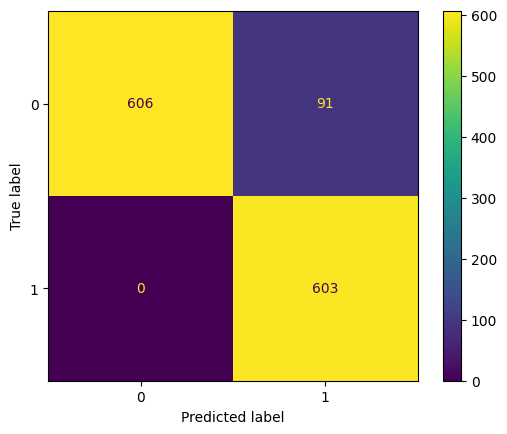

In [ ]:
# 4. Select Best Model and Analyze
best_model_from_grid = grid_search_target.best_estimator_

# Model Analysis (ROC, Feature Importance, CV Predictions) 
RocCurveDisplay.from_estimator(best_model_from_grid, X_test, y_test)
plt.show()


# 5. Threshold Tuning 
def cost_balanced_score(y_true, y_pred):

    # Define the costs of the two kinds of error
    fp_cost = 3
    fn_cost = 100

    # Get error frequencies
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Multiply errors by their costs
    total_error = (fp * fp_cost) + (fn * fn_cost)

    # Return negative error (sklearn will try to maximize the score)
    return -total_error

# Turn function into sklearn scorer
cost_balance = make_scorer(cost_balanced_score)

splitter = KFold(n_splits=10, shuffle=True, random_state=42)
tuned_thresh_model = TunedThresholdClassifierCV(
    estimator=best_model_from_grid, 
    scoring=cost_balance,
    cv=splitter
)
tuned_thresh_model.fit(X_train, y_train) 


# 6. Final Evaluation 
# Now, for the first time, we use the test set to get the final performance.
print("\n Final Evaluation on Test Set with Tuned Threshold")
final_preds = tuned_thresh_model.predict(X_test)

# Display performance
acc = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)

print(
  f'Final Accuracy: {round(acc, 4)}\n'
  f'Final Precision: {round(precision, 4)}\n'
  f'Final Recall: {round(recall, 4)}\n'
)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=final_preds)
plt.show();


--- Applying a Manual Threshold ---

--- Final Evaluation on Test Set with Manual Threshold of 0.02 ---
Manual Threshold Accuracy: 0.9046
Manual Threshold Precision: 0.8294
Manual Threshold Recall: 1.0



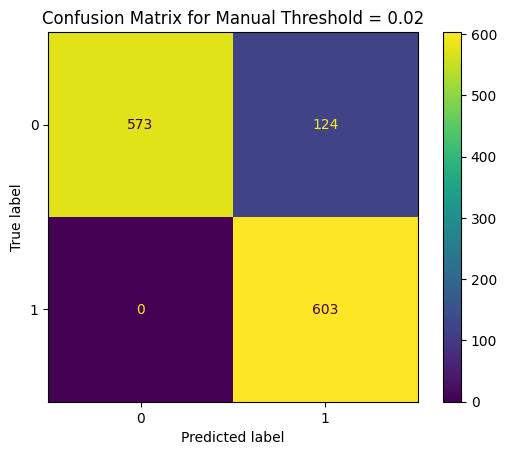

In [ ]:
# Step 7: Applying a Manual Threshold (for Experimentation) 

y_probs = best_model_from_grid.predict_proba(X_test)[:, 1]

manual_threshold = 0.02

manual_preds = (y_probs >= manual_threshold).astype(int)


print(f"\nFinal Evaluation on Test Set with Manual Threshold of {manual_threshold}")
acc_manual = accuracy_score(y_test, manual_preds)
precision_manual = precision_score(y_test, manual_preds)
recall_manual = recall_score(y_test, manual_preds)

print(
  f'Manual Threshold Accuracy: {round(acc_manual, 4)}\n'
  f'Manual Threshold Precision: {round(precision_manual, 4)}\n'
  f'Manual Threshold Recall: {round(recall_manual, 4)}\n'
)

# Display the new confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=manual_preds)
plt.title(f"Confusion Matrix for Manual Threshold = {manual_threshold}")
plt.show();

In [ ]:
# We need to reorder columns to submit our resaults for competition
training_columns = X.columns.tolist()
test_df_reordered = test_df[training_columns]
test_df_reordered = test_df_reordered.astype(str)

In [ ]:
# 1. Get the probabilities for the 'poisonous' class on the competition data
competition_probs = best_model_from_grid.predict_proba(test_df_reordered)[:, 1]

# 2. Define the manual threshold you decided to use
# This should be the value you found best during your experimentation
manual_threshold = 0.04
print(f"Using manual threshold: {manual_threshold}")

# 3. Apply the threshold to the probabilities to get the final 0 or 1 predictions
competition_predictions = (competition_probs >= manual_threshold).astype(int)

# 4. Create the submission file in the correct format
# competition requires 'id' and 'poisonous' columns
submission_df = pd.DataFrame({
    'Id': test_df_reordered.index, 
    'poisonous': competition_predictions
})

# Save the submission file
submission_df.to_csv('./submission-sahand.csv', index=False)

Using manual threshold: 0.04


But our tuned threshold was doing better.

In [ ]:


# Use the pipeline to preprocess the new data and make predictions
test_df_reordered['poisonous'] = tuned_thresh_model.predict(test_df_reordered)

test_df_reordered['poisonous'].to_csv('./submission-sahand.csv')

# With Stacking

--- Tuning RandomForest Model ---
Best cross-validation score for RandomForest: 0.9565

--- Building and Training Stacking Model ---
Stacking model trained.

--- Comparing Model Performance on Test Set ---
Tuned RandomForest Test Accuracy: 0.9623
Stacking Model Test Accuracy: 0.9638

Stacking performed better. Proceeding with Stacking model.

--- Tuning threshold on the winning model ---


C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best threshold found: 0.06

--- Final Evaluation on Test Set with Tuned Threshold ---
Final Accuracy: 0.9423
Final Precision: 0.8905
Final Recall: 0.9983



C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


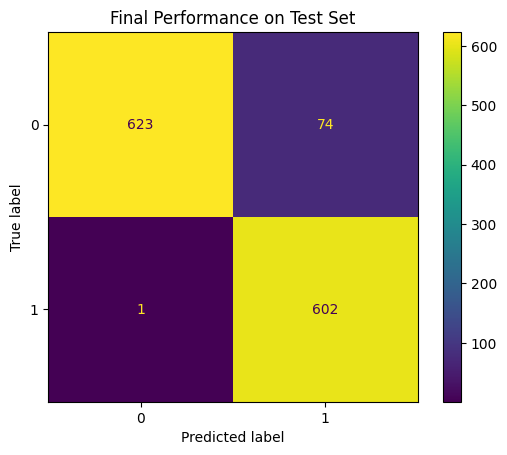

In [ ]:
# 1. Data Preparation

X = train_df
y = X.pop('poisonous')
X = X.astype(str)
test_df[X.columns]
all_feature_names = X_train.columns.tolist()

# 2. Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)


# 3. Model Building & Tuning 

# 3a. Tune RandomForest with OneHotEncoder
print("--- Tuning RandomForest Model ---")
pipeline_rf = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    RandomForestClassifier(random_state=314)
)
rf_params = {
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__max_depth': [None],
}
grid_search_rf = GridSearchCV(pipeline_rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print(f"Best cross-validation score for RandomForest: {grid_search_rf.best_score_:.4f}\n")


# 3b. Build and Train Stacking Classifier
print("Building and Training Stacking Model")

base_estimators = [
    (
        'random_forest',
        make_pipeline(
            OneHotEncoder(handle_unknown='ignore'),
            RandomForestClassifier(n_estimators=100, random_state=42)
        )
    ),
    (
        'light_gbm',
        make_pipeline(
            OneHotEncoder(handle_unknown='ignore'),
            lgb.LGBMClassifier(random_state=42)
        )
    ),
    (
        'xgboost',
        make_pipeline(
            OneHotEncoder(handle_unknown='ignore'),
            xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        )
    ),
    (
        # CatBoost handles categorical features natively, so no OneHotEncoder is needed.
        'catboost',
        CatBoostClassifier(verbose=0, cat_features=all_feature_names, random_state=42)
    )
]

# Define the meta-model that combines the base model predictions
meta_model = LogisticRegression()

# Create the Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)
print("Stacking model trained.\n")


# 4. Compare Models & Select Best
print("--- Comparing Model Performance on Test Set ---")
# Get the best tuned RandomForest pipeline from the grid search
best_rf_model = grid_search_rf.best_estimator_

# Score both models on the test set to see which is better
rf_score = best_rf_model.score(X_test, y_test)
stacking_score = stacking_model.score(X_test, y_test)

print(f"Tuned RandomForest Test Accuracy: {rf_score:.4f}")
print(f"Stacking Model Test Accuracy: {stacking_score:.4f}")

# Programmatically select the best model to proceed with
if rf_score > stacking_score:
    print("\nRandomForest performed better. Proceeding with RandomForest.")
    best_overall_model = best_rf_model
else:
    print("\nStacking performed better. Proceeding with Stacking model.")
    best_overall_model = stacking_model


# 5. Threshold Tuning (on the Winning Model)
# Custom cost function
def cost_balanced_score(y_true, y_pred):
    fp_cost = 3
    fn_cost = 100
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError: # Handles cases where a class is not predicted
        return 0
    total_error = (fp * fp_cost) + (fn * fn_cost)
    return -total_error

cost_balance = make_scorer(cost_balanced_score)
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the threshold tuner on the best overall model
tuned_thresh_model = TunedThresholdClassifierCV(
    estimator=best_overall_model,
    scoring=cost_balance,
    cv=splitter,
    n_jobs=-1
)
print("\n Tuning threshold on the winning model")
tuned_thresh_model.fit(X_train, y_train)
print(f"Best threshold found: {tuned_thresh_model.best_threshold_:.2f}")


# 6. Final Evaluation 
print("\nFinal Evaluation on Test Set with Tuned Threshold")
final_preds = tuned_thresh_model.predict(X_test)

# Display final performance
acc = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)

print(
  f'Final Accuracy: {round(acc, 4)}\n'
  f'Final Precision: {round(precision, 4)}\n'
  f'Final Recall: {round(recall, 4)}\n'
)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=final_preds)
plt.title("Final Performance on Test Set")
plt.show();


--- Applying a Manual Threshold ---

--- Final Evaluation on Test Set with Manual Threshold of 0.02 ---
Manual Threshold Accuracy: 0.9392
Manual Threshold Precision: 0.8842
Manual Threshold Recall: 1.0



C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


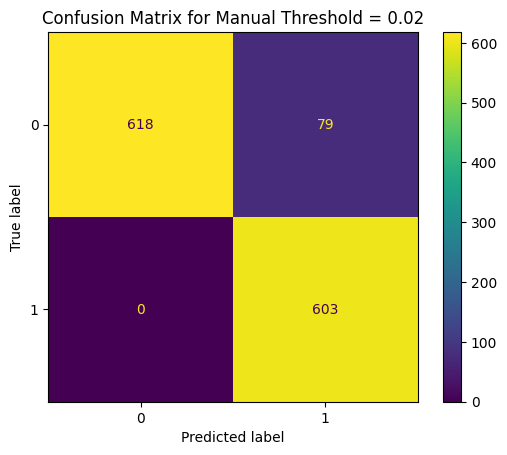

In [ ]:
# Step 7: Applying a Manual Threshold (for Experimentation)

print("\nApplying a Manual Threshold")

y_probs = tuned_thresh_model.predict_proba(X_test)[:, 1]

manual_threshold = 0.02

manual_preds = (y_probs >= manual_threshold).astype(int)


print(f"\nFinal Evaluation on Test Set with Manual Threshold of {manual_threshold}")
acc_manual = accuracy_score(y_test, manual_preds)
precision_manual = precision_score(y_test, manual_preds)
recall_manual = recall_score(y_test, manual_preds)

print(
  f'Manual Threshold Accuracy: {round(acc_manual, 4)}\n'
  f'Manual Threshold Precision: {round(precision_manual, 4)}\n'
  f'Manual Threshold Recall: {round(recall_manual, 4)}\n'
)

# Display the new confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=manual_preds)
plt.title(f"Confusion Matrix for Manual Threshold = {manual_threshold}")
plt.show();

In [ ]:
training_columns = X.columns.tolist()
test_df_reordered = test_df[training_columns]
test_df_reordered = test_df_reordered.astype(str)

In [ ]:
# 1. Get the probabilities for the 'poisonous' class on the competition data
competition_probs = best_model_from_grid.predict_proba(test_df_reordered)[:, 1]

# 2. Define the manual threshold you decided to use
# This should be the value you found best during your experimentation (e.g., 0.10)
manual_threshold = 0.02
print(f"Using manual threshold: {manual_threshold}")

# 3. Apply the threshold to the probabilities to get the final 0 or 1 predictions
competition_predictions = (competition_probs >= manual_threshold).astype(int)

# 4. Create the submission file in the correct format
# (the competition requires 'id' and 'poisonous' columns)
submission_df = pd.DataFrame({
    'Id': test_df_reordered.index, 
    'poisonous': competition_predictions
})

# Save the submission file
submission_df.to_csv('./submission-sahand.csv', index=False)

Using manual threshold: 0.02


In [134]:
# Reset index so 'Id' is a column for prediction

# Use the pipeline to preprocess the new data and make predictions
test_df_reordered['poisonous'] = tuned_thresh_model.predict(test_df_reordered)

test_df_reordered['poisonous'].to_csv('./submission-sahand.csv')

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
